In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import scipy.stats as stats

from pandas.api.types import CategoricalDtype

from statsmodels.miscmodels.ordinal_model import OrderedModel
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

In [110]:
house_data = pd.read_csv('data/kc_house_data.csv')
house_data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [276]:
test = house_data.groupby('view')
test.

id                                                        \
             count          mean           std         min           25%   
view                                                                       
AVERAGE      836.0  4.795880e+09  2.936577e+09  31000165.0  2.284750e+09   
EXCELLENT    290.0  4.985087e+09  2.935524e+09  98001070.0  2.541587e+09   
FAIR         291.0  4.608214e+09  2.714042e+09  34001160.0  2.487201e+09   
GOOD         435.0  4.456650e+09  2.890868e+09  46100350.0  1.939355e+09   
NONE       17312.0  4.581009e+09  2.874748e+09   1000102.0  2.121779e+09   

                                                       price                \
                    50%           75%           max    count          mean   
view                                                                         
AVERAGE    4.153052e+09  7.633500e+09  9.830200e+09    836.0  7.948774e+05   
EXCELLENT  4.082951e+09  7.855150e+09  9.829200e+09    290.0  1.462409e+06   
FAIR       4.019301e+09  7.129301e+09  9.830200e+09    291.0  8.124678e+05   
GOOD       3.880900e+09  7.474500e+09  9.808630e+09    435.0  9.831309e+05   
NONE       3.904911e+09  7.304301e+09  9.900000e+09  17312.0  4.981297e+05   

           ... sqft_living15         sqft_lot15                              \
           ...           75%     max      count          mean           std   
view       ...                                                                
AVERAGE    ...        2860.0  5500.0      836.0  18133.395933  46350.998927   
EXCELLENT  ...        3295.0  5380.0      290.0  19222.758621  28113.933614   
FAIR       ...        2805.0  4190.0      291.0  10481.687285  10492.128852   
GOOD       ...        3145.0  6110.0      435.0  22759.000000  53024.778799   
NONE       ...        2270.0  6210.0    17312.0  12220.990296  25420.921098   

                                                         
              min      25%      50%       75%       max  
view                                                     
AVERAGE    1057.0  5749.00   8277.0  12598.50  858132.0  
EXCELLENT  1505.0  8400.50  12620.0  19718.75  248292.0  
FAIR       1249.0  6011.50   8720.0  11904.50  127195.0  
GOOD       1284.0  6000.00   9134.0  15193.50  560617.0  
NONE        651.0  5016.75   7546.5   9860.00  871200.0  

[5 rows x 120 columns]

In [277]:
house_data.zipcode.value_counts()

98103    540
98038    528
98115    515
98052    506
98117    495
        ... 
98102     89
98010     87
98024     73
98148     51
98039     45
Name: zipcode, Length: 70, dtype: int64

In [255]:
test_data = house_data[['id', 'bedrooms', 'bathrooms', 'sqft_living', 'floors',
                        'condition','grade', 'yr_built', 'zipcode', 'view', 'price'
                       ]].copy()

# Drop id nulls and duplicates 
test_data.drop_duplicates(subset= 'id', keep='first', inplace=True, ignore_index = True)


# bedrooms drop all greater than 6
test_data.drop(test_data.index[test_data['bedrooms'] >= 7], inplace = True)


#bathrooms remove all bathroom values less than 1 , greater than 4 
# test_data = test_data[test_data.bathrooms >= 1.0]
# test_data = test_data[test_data.bathrooms <= 4.0]
test_data['bathrooms'] = test_data['bathrooms'].dropna()


# sqft_living drop above 5000
# test_data = test_data[test_data.sqft_living < 5000]



# May potentially reduce range of year built -- cutoff around 1920

# Price drop outliers 
# test_data = test_data[test_data.price < 2000000]
test_data['price'] = test_data['price'].map(lambda x: np.log(x)) #UNDO_______________   


# Waterfront drop nulls 
house_data = house_data[house_data['waterfront'].notna()]
# **************************************************************************************
# ABOVE IS GOOD 







# test_data[nom_features].shape

In [256]:
# house_data = house_data[house_data['waterfront'].notna()]
# len(house_data.waterfront.isna() == True)
test_data = test_data[test_data['view'].notna()]
test_data.view

0        NONE
1        NONE
2        NONE
3        NONE
4        NONE
         ... 
19082    NONE
19083    NONE
19084    NONE
19085    NONE
19086    NONE
Name: view, Length: 19030, dtype: object

In [271]:
ord_cat_selector = ['condition', 'grade', 'view'] # ----original
# ord_cat_selector = ['view'] #----test


cat_subset = test_data[ord_cat_selector]
cat_subset

ordered_condition = ['Poor', 'Fair', 'Average', 'Good', 'Very Good']
ordered_grade = ['3 Poor', '4 Low', '5 Fair', '6 Low Average', '7 Average','8 Good',
                 '9 Better', '10 Very Good', '11 Excellent','12 Luxury', 
                 '13 Mansion']
ordered_view = ['NONE', 'AVERAGE', 'GOOD', 'FAIR', 'EXCELLENT']

o_enc = OrdinalEncoder(categories = [ordered_condition, ordered_grade, ordered_view]) # --- original
# o_enc = OrdinalEncoder(categories = [ordered_view]) # ---test


o_enc.fit(cat_subset)

X_subset = pd.DataFrame(o_enc.transform(cat_subset),
                        columns = cat_subset.columns)
X_subset.shape
# o_enc

(19030, 3)

/Users/austinboring/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='condition', ylabel='yr_built'>

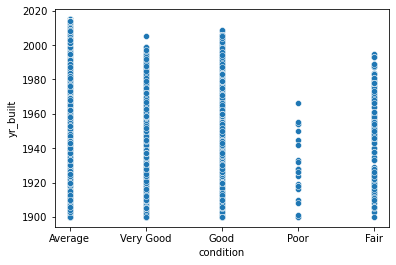

In [274]:
# pd.plotting.scatter_matrix(test_data[['bedrooms', 'bathrooms', 'sqft_living', 'floors',
#                         'condition','grade', 'yr_built', 'zipcode', 'price']], figsize=(10,12));

sns.scatterplot(test_data.condition, test_data.yr_built)

In [259]:
# test_data.waterfront


In [260]:
house_data.view.value_counts()

NONE         17312
AVERAGE        836
GOOD           435
FAIR           291
EXCELLENT      290
Name: view, dtype: int64

In [261]:
lr = LinearRegression()
lr

LinearRegression()

In [262]:
# pd.plotting.scatter_matrix(test_data[nom_features], figsize=(10,12)); 

In [282]:

# nom_features = ['bathrooms', 'sqft_living', 'floors', 'zipcode', 'price'] #test
# nom_features = ['bedrooms','bathrooms', 'sqft_living', 'floors', 'zipcode', 'price'] #test
nom_features = ['sqft_living', 'zipcode', 'price'] #test





# nom_features = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'yr_built', 'zipcode', 'price'] #original
ord_features = X_subset
# dum_waterfront = pd.get_dummies(house_data['waterfront'], prefix = 'wtr', drop_first = True)
# X_ = pd.concat([test_data[nom_features], X_subset, dum_waterfront],join = 'inner', axis = 1) #-- original
X_ = pd.concat([test_data[nom_features], X_subset],join = 'inner', axis = 1) #--test


X = X_.drop(columns = 'price')
y = X_['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [283]:
X_.corr()

,sqft_living,zipcode,price,condition,grade,view
sqft_living,1.000000,-0.194412,0.696285,-0.017469,0.024651,-0.000687
zipcode,-0.194412,1.000000,-0.032111,0.004031,-0.005129,-0.000387
price,0.696285,-0.032111,1.000000,-0.014028,0.010863,-0.004847
condition,-0.017469,0.004031,-0.014028,1.000000,-0.147234,0.048197
grade,0.024651,-0.005129,0.010863,-0.147234,1.000000,0.224967
view,-0.000687,-0.000387,-0.004847,0.048197,0.224967,1.000000


In [284]:
# dum_waterfront # 19221
# X_ # 21310
# test_data[nom_features] #18557
# ord_features# 18557

In [285]:
X2 = sm.add_constant(X)
_1  = sm.OLS(y, X2)
_2  = _1.fit()

print(_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     3733.
Date:                Fri, 01 Apr 2022   Prob (F-statistic):               0.00
Time:                        11:54:52   Log-Likelihood:                -8275.7
No. Observations:               18974   AIC:                         1.656e+04
Df Residuals:                   18968   BIC:                         1.661e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -91.6582      5.088    -18.014      

In [267]:
lr.fit(X_train, y_train)

LinearRegression()

In [268]:
lr.coef_

array([-0.06167987,  0.11710635,  0.0003774 ,  0.12895452, -0.00445211,
        0.00039853, -0.00450086])

In [269]:
lr.score(X_train, y_train)

0.53992205546518

In [210]:
X.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'yr_built', 'zipcode',
       'condition', 'grade', 'view', 'wtr_YES'],
      dtype='object')

In [211]:
# This gets the predictions of model on test set.
y_pred = lr.predict(X_test)
#get first ten elements of prediction.
y_pred[0:10]

array([12.97019113, 13.47530251, 13.31905935, 12.85907008, 13.92933329,
       13.30797761, 13.82490558, 13.59074964, 12.39431408, 13.39672735])

In [212]:
MAE = mean_absolute_error(y_pred, y_test)
MAE

0.2864330786167961

In [213]:
RMSE = np.sqrt(mean_squared_error(y_pred, y_test))
RMSE

0.35873538437064767

In [71]:
# lr.summary()

In [ ]:
"""
sqft, zipcode, grade -- median price 


"""